<a href="https://colab.research.google.com/github/ganeshhep/JETS/blob/main/task_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations

In [1]:
!pip install uproot
!pip install fastjet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.2/351.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 791.3/791.3 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.8/692.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 19.2 MB/s eta 0:00:00


## Imports

In [2]:
import itertools
import uproot
from fastjet import PseudoJet, JetDefinition, ClusterSequence, antikt_algorithm, sorted_by_pt, join
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Loading the data
from google.colab import drive
drive.mount('/content/drive')
data_file = "/content/drive/MyDrive/tutorial5_new.root"

Mounted at /content/drive


In [4]:
tree = uproot.open(data_file)['tree']

In [5]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
n                    | int32_t                  | AsDtype('>i4')
charge               | double                   | AsDtype('>f8')
is_charged           | int8_t                   | AsDtype('int8')
is_neutral           | int8_t                   | AsDtype('int8')
isbHadron            | int8_t                   | AsDtype('int8')
mother_b_hadron      | int8_t                   | AsDtype('int8')
px                   | double                   | AsDtype('>f8')
py                   | double                   | AsDtype('>f8')
pz                   | double                   | AsDtype('>f8')
e                    | double                   | AsDtype('>f8')
b_hadron_px          | double                   | AsDtype('>f8')
b_hadron_py          | double                   | AsDtype('>f8')
b_hadron_pz          | double                   | AsDt

In [6]:
tree.num_entries # This is the sum total of number of all the particles obtained at the final state of all the events.

3908853

In [7]:
table = tree.arrays(library = 'ak') # a list of dictionaries

In [8]:
def f(R) : # R is the radius parameter
  n_jets = [] # a list containing number of jets in each event
  n_bjets = [] # a list containing number of b-jets in each event
  n_wjets = [] # a list containing number of w-jets in each event
  jet_pT = [] # a list containing jets pT
  jet_eta = [] # a list containing jets eta
  w_jet_inv_mass = [] # a list containing invariant masses of w-jets

  l_event = 0

  N = 500 # number of events

  for n in range(N) : # taking upto N events
      event_n = table[table['n'] == n + 1]

      particles = [] # a list of particles in an event
      jet_list = [] # a list of jets in an event
      b_jets_list = [] # a list of b-jets in an event
      #double_jet_list = []

      inv_mass = []

      k = 0 # k is the number of b-jets in an event

      for i in range(len(event_n)) : # looping over the particles in an event
        part_p4 = PseudoJet(event_n[i]['px'], event_n[i]['py'], event_n[i]['pz'], event_n[i]['e'])
        part_p4.set_user_index(l_event + i) # labeling the particle by it's index in the 'table' array i.e 1st particle by '0', 2nd by '1', 3rd by '2' and so on and so forth
        particles.append(part_p4)

      l_event += len(event_n)

      # Applying clustering of particles with anti-kt algorithm
      cluster = ClusterSequence(particles, JetDefinition(antikt_algorithm, R))
      jet_set = sorted_by_pt(cluster.inclusive_jets(ptmin = 10.0)) # Jets obtained from inclusive form of clustering algorithm, sorted by pT (decreasing pT) and pT > 10.0 GeV

      for i in range(len(jet_set)) : # looping over jets
          jet_p4 = jet_set[i]
          jet_p4.set_user_index(i + 1) # labeling each jet, 1st jet by'1', 2nd jet by '2', 3rd jet by '3' and so on and so forth
          jet_list.append(jet_p4)
          jet_pT.append(jet_p4.pt())
          jet_eta.append(jet_p4.eta())

          const_jet = cluster.constituents(jet_set[i]) # constituents of a jet

          # Identifying b-jet
          for j in range(len(const_jet)) : # looping over constituents of a jet
            if table[const_jet[j].user_index()]['isbHadron'] == 1 :
              k += 1
              break

            elif table[const_jet[j].user_index()]['mother_b_hadron'] == 1 :
              b_hadron_px = table[const_jet[j].user_index()]['b_hadron_px']
              b_hadron_py = table[const_jet[j].user_index()]['b_hadron_py']
              b_hadron_pz = table[const_jet[j].user_index()]['b_hadron_pz']
              b_hadron_e = table[const_jet[j].user_index()]['b_hadron_e']

              b_hadron = PseudoJet(b_hadron_px, b_hadron_py, b_hadron_pz, b_hadron_e)

              del_R = ((jet_p4.eta() - b_hadron.eta())**2 + (jet_p4.phi() - b_hadron.phi())**2)**0.5

              if del_R < R :
                k += 1
                break

      # Identifying w-jet
     # while len(jet_list) > 1 :
        #d_R = 1000
        #for j in range(len(jet_list)) :
          #delta_R = ((jet_list[0].eta() - jet_list[j].eta())**2 + (jet_list[0].phi() - jet_list[j].phi())**2)**0.5
          #if delta_R != 0 and delta_R < d_R :
            #m = j
            #d_R = delta_R

        #double_jet = jet_list[m] + jet_list[0]
        #double_jet_list.append(double_jet)

        #jet_list.remove(jet_list[m])
        #jet_list.remove(jet_list[0])

      #for p in range(len(double_jet_list)) :
        #if double_jet_list[p].m() > 70 and double_jet_list[p].m() < 90 :
          #w_jet_inv_mass.append(double_jet_list[p].m())

      if len(jet_list) != 0 and len(jet_list) != 1 :
        for i in range(len(jet_list) - 1) :
          d_R = 1000
          for j in range(i + 1, len(jet_list)) :
            double_jet = jet_list[i] + jet_list[j]
            d_jet_mass = double_jet.m()
            delta_R = ((jet_list[i].eta() - jet_list[j].eta())**2 + (jet_list[i].phi() - jet_list[j].phi())**2)**0.5

            if d_jet_mass > 70 and d_jet_mass < 90 :
              if delta_R < d_R :
                mass = d_jet_mass
                d_R = delta_R

          w_jet_inv_mass.append(mass)

      #print(n_w_jet)
      #jet_pair = itertools.combinations(jet_list, r = 2)

      #for pair in jet_pair :
         #double_jet = join(pair[0], pair[1])
         #if double_jet.m() > 70 and double_jet.m() < 90 :
          #indx = int(str(pair[0].user_index()) + str(pair[1].user_index()))
          #double_jet.set_user_index(indx)
          #w_jet_inv_mass.append(double_jet.m())

      n_jets.append(len(jet_set))
      n_bjets.append(k)

  plt.hist(n_jets, bins = np.arange(0, 15), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("Number of jets")
  plt.ylabel("Number of events")
  plt.legend()
  plt.show()

  plt.hist(n_bjets, bins = np.arange(0, 10), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("Number of b-jets")
  plt.ylabel("Number of events")
  plt.legend()
  plt.show()

  plt.hist(np.log(jet_pT), bins = np.arange(0, 11), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("log(pT)")
  plt.legend()
  plt.show()

  plt.hist(jet_eta, bins = np.arange(-10, 10), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("Jet-eta")
  plt.legend()
  plt.show()

  plt.hist(w_jet_inv_mass, bins = np.arange(65, 95), label = 'R = ' + str(R), color = 'blue', histtype = 'step', linewidth = 2.)
  plt.xlabel("invariant mass of w-jets")
  plt.legend()
  plt.show()

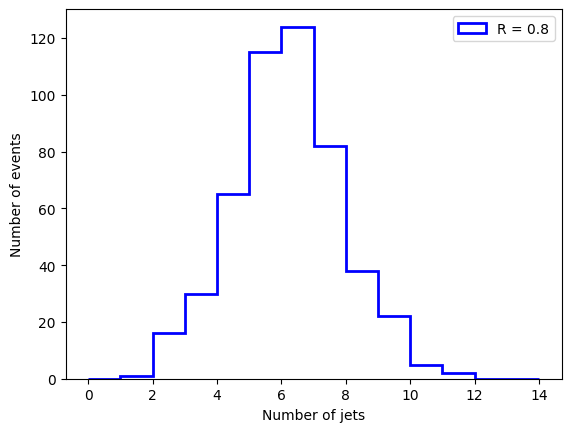

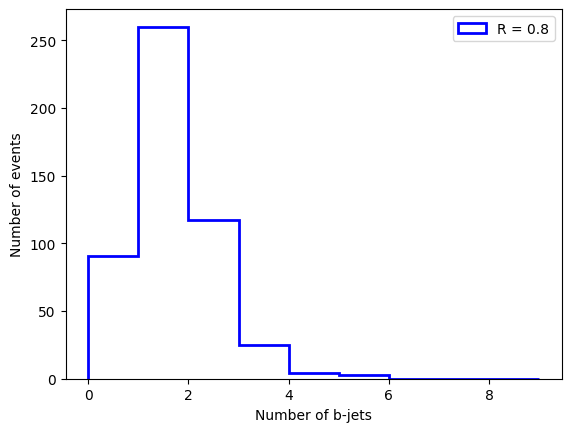

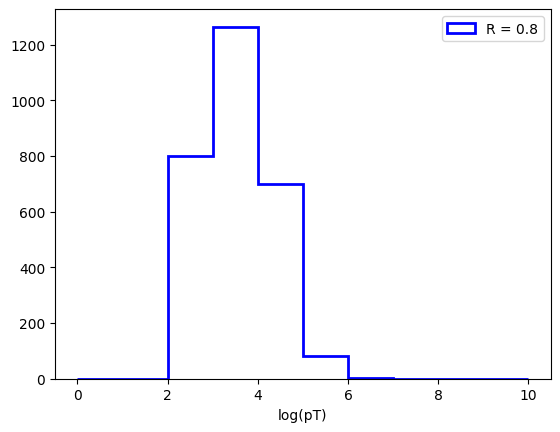

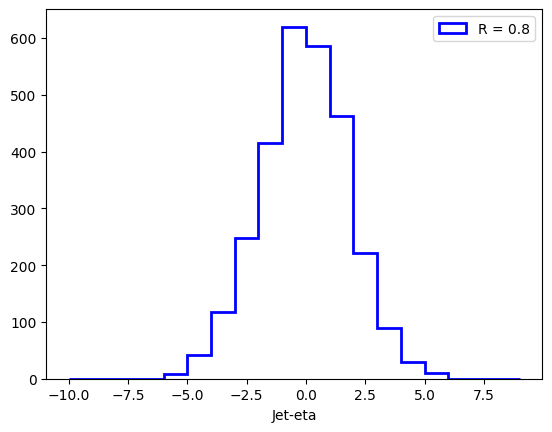

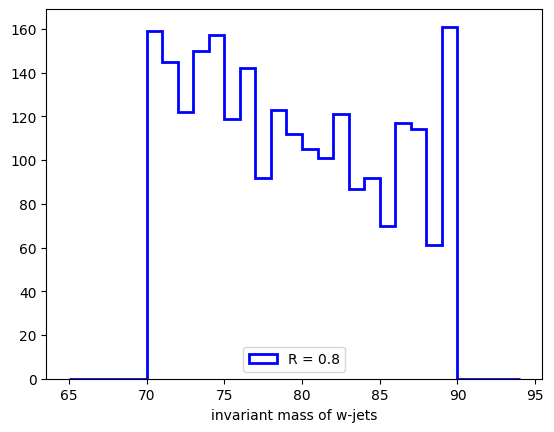

In [10]:
f(0.8)

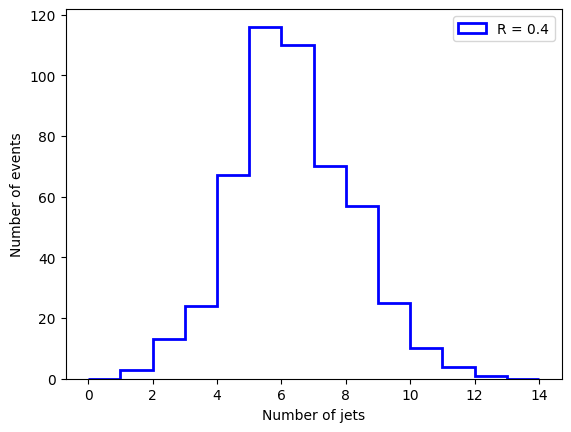

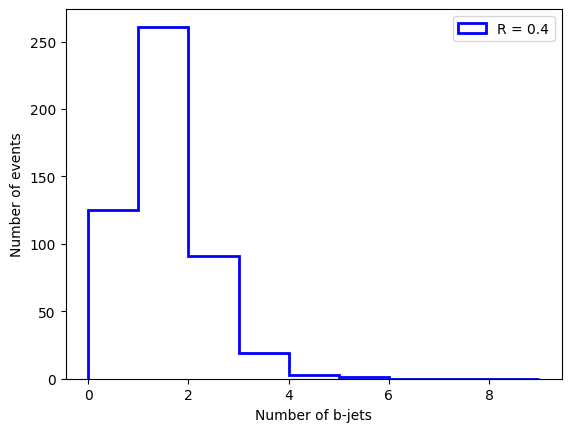

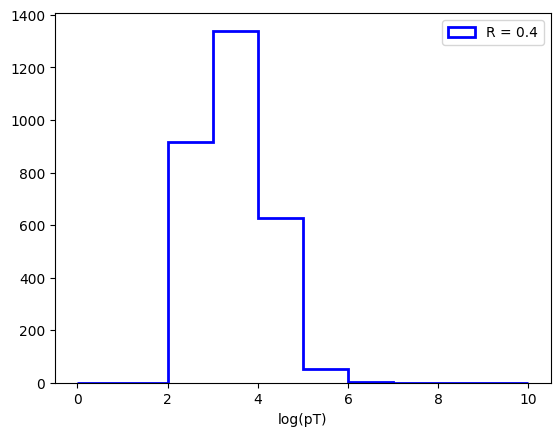

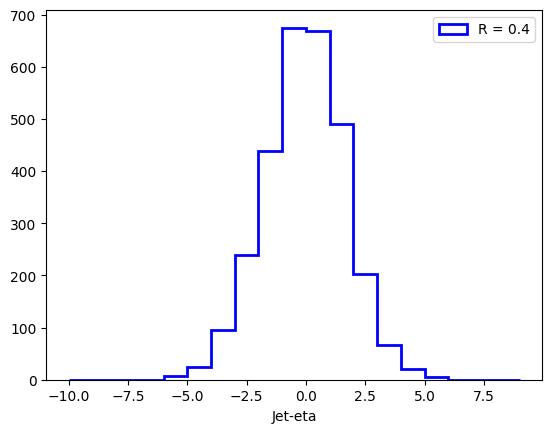

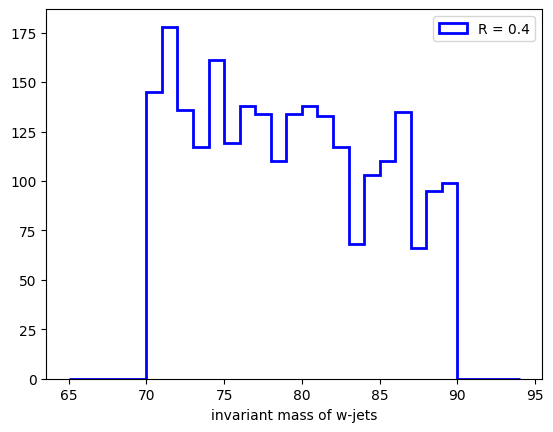

In [11]:
f(0.4)